In [49]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

tf.random.set_seed(2) #设置随机数种子


In [2]:
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()

    return fix_df

In [3]:
# 读取数据
his_nmp_fd_df = pd.read_csv('.\\data\\FD001\\03 His_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_power_fd_df = pd.read_csv('.\\data\\FD001\\02_His_Power_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_fd_df=preprocessing(his_nmp_fd_df,his_power_fd_df)
his_fd_df.to_csv('his_df.csv',encoding = 'utf-8') #存储合并后数据

In [4]:
df=pd.read_csv('his_df.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-15 00:00:00,3.3696,290.3172,4.1829,295.0334,4.9253,297.9698,5.6139,300.0360,6.2446,301.5774,6.5423,302.1353,27.59,1003.96,93.20,0.0216
2022-07-15 00:15:00,3.3092,291.4477,4.1100,296.1286,4.8389,299.0546,5.5137,301.1241,6.1388,302.6287,6.4347,303.2702,27.61,1004.37,93.05,0.0218
2022-07-15 00:30:00,3.4671,295.0868,4.2669,299.3285,5.0000,302.0054,5.6718,303.8582,6.2926,305.2307,6.5832,305.7906,27.62,1004.25,92.96,0.4021
2022-07-15 00:45:00,3.6896,296.9123,4.4933,300.7888,5.2253,303.4468,5.9067,305.1430,6.5341,306.5367,6.8241,307.1386,27.62,1003.96,92.82,0.5867
2022-07-15 01:00:00,3.7095,298.4995,4.5220,302.3546,5.2791,304.8942,5.9740,306.6973,6.6113,307.9966,6.9170,308.5434,27.64,1003.68,92.59,0.3889


In [5]:
df.tail()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597
2022-07-21 23:30:00,3.2299,299.8989,4.5556,308.4045,5.8027,312.7652,6.6115,314.9387,6.7961,315.8942,6.8890,316.2939,27.46,1009.84,0.00,3.4466
2022-07-21 23:45:00,3.4215,297.3140,4.7503,306.2668,6.0103,311.0873,6.7556,313.3806,6.9372,314.3576,7.0216,314.8269,27.46,1009.69,0.00,3.0725


In [6]:
df.shape

(672, 16)

In [7]:
# 划分train valid test集
fd_df_train = df[:int(0.6*len(df))]
fd_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
fd_df_test =df[int(0.8*len(df)):]

In [8]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(fd_df_train)
df_for_validing_scaled=scaler.transform(fd_df_valid)
df_for_testing_scaled=scaler.transform(fd_df_test)

In [9]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

In [10]:
df_X,df_y=createXY(np.array(df))

In [11]:
train_X.shape

(396, 7, 16)

In [12]:
train_y.shape

(396,)

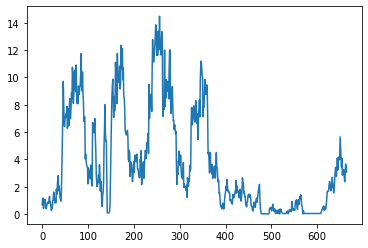

In [13]:
plt.plot(range(len(df_y)), df_y, label='history')

In [14]:
# 回调函数callbacks
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [15]:
def build_model(optimizer,num):
    # Create grid_model
    grid_model = Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(num))
    grid_model.add(tf.keras.layers.Dense(num))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [16]:
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valid_X,valid_y))

C:\Users\23966\AppData\Local\Temp\ipykernel_21864\4274252830.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valid_X,valid_y))


In [17]:
def easy_doing(begin,end,step):
    value=[]
    i=begin
    for i in np.arange(begin, end, step):
        value.append(i)
    return value

In [18]:
parameters = {'num' : [56,64,72],'batch_size' : [20,22],'epochs' : [45,50],'optimizer' : ['adam'] }
# {'batch_size': 20, 'epochs': 50, 'num': 68, 'optimizer': 'adam'}

In [19]:
# parameters = {'batch_size' : easy_doing(12,32,4),'epochs' :easy_doing(20,120,10),'optimizer' : ['adam'],'num' : easy_doing(32,72,4), }

In [20]:
grid_search = GridSearchCV(estimator = grid_model,
                          param_grid = parameters,
                          cv = 2)

In [21]:
grid_search = grid_search.fit(train_X, train_y,)

Epoch 1/45
10/10 [==============================] - 2s 47ms/step - loss: 0.1081 - val_loss: 0.0680
Epoch 2/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0273 - val_loss: 0.0405
Epoch 3/45
10/10 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.0403
Epoch 4/45
10/10 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0234
Epoch 5/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 6/45
10/10 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0144
Epoch 7/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 8/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 9/45
10/10 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 10/45
10/10 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 0.0022
Epoch 11/45
10/10 

10/10 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0155
Epoch 39/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0153
Epoch 40/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0135
Epoch 41/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0118
Epoch 42/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0128
Epoch 43/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0144
Epoch 44/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0134
Epoch 45/45
10/10 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 1/45
10/10 [==============================] - 2s 42ms/step - loss: 0.0431 - val_loss: 0.0174
Epoch 2/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0180 - val_loss: 0.0111
Epoch 3/45
10/10 [========================

10/10 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0111
Epoch 30/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0096
Epoch 31/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0084
Epoch 32/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0086
Epoch 33/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 34/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 35/45
10/10 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0094
Epoch 36/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0098
Epoch 37/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0097
Epoch 38/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0125
Epoch 39/45
10/10 [===

10/10 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0100
Epoch 21/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0096
Epoch 22/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 23/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 24/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 25/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0114
Epoch 26/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 27/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 28/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0117
Epoch 29/45
10/10 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0094
Epoch 30/45
10/10 [===

10/10 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0043
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0057
Epoch 8/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0062
Epoch 9/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 10/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0048
Epoch 11/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 12/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 13/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0113
Epoch 14/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 15/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0100
Epoch 16/50
10/10 [======

10/10 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 39/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 40/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 41/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0033
Epoch 42/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 43/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 44/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0086
Epoch 45/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.0141
Epoch 46/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 47/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0116
Epoch 48/50
10/10 [===

10/10 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0107
Epoch 20/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0023
Epoch 21/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0027
Epoch 22/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0027
Epoch 23/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 24/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 25/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 26/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0174
Epoch 27/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 28/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 29/50
10/10 [===

10/10 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 1/45
9/9 [==============================] - 2s 71ms/step - loss: 0.1194 - val_loss: 0.1108
Epoch 2/45
9/9 [==============================] - 0s 5ms/step - loss: 0.0309 - val_loss: 0.0332
Epoch 3/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0652
Epoch 4/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0191
Epoch 5/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0069
Epoch 6/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 7/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0041
Epoch 8/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0028
Epoch 9/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 0.0021
Epoch 10/45
9/9 [==============================] - 0s 7ms/step - lo

9/9 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 40/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0083
Epoch 41/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 42/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 43/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0096
Epoch 44/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 45/45
9/9 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 1/45
9/9 [==============================] - 2s 72ms/step - loss: 0.0557 - val_loss: 0.0195
Epoch 2/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0233 - val_loss: 0.0222
Epoch 3/45
9/9 [==============================] - 0s 8ms/step - loss: 0.0177 - val_loss: 0.0662
Epoch 4/45
9/9 [==============================] - 0s 7ms/step -

9/9 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0139
Epoch 33/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0127
Epoch 34/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0148
Epoch 35/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0138
Epoch 36/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0139
Epoch 37/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0150
Epoch 38/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0141
Epoch 39/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0149
Epoch 40/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0201
Epoch 41/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0113
Epoch 42/45
9/9 [=========================

9/9 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0174
Epoch 26/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0146
Epoch 27/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0109
Epoch 28/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0137
Epoch 29/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0134
Epoch 30/45
9/9 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0111
Epoch 31/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0128
Epoch 32/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0158
Epoch 33/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0110
Epoch 34/45
9/9 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0147
Epoch 35/45
9/9 [=========================

9/9 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 14/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 15/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 16/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 17/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 18/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 19/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 20/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 21/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 22/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 23/50
9/9 [=========================

Epoch 47/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 48/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 49/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0066
Epoch 50/50
9/9 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 1/50
9/9 [==============================] - 2s 71ms/step - loss: 0.0611 - val_loss: 0.0692
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0280 - val_loss: 0.0389
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0284
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0163 - val_loss: 0.0215
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0065
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 7/50
9/9 [==============================] - 0s 7

9/9 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 31/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 32/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 33/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 34/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 35/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 36/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 37/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 38/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 39/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 40/50
9/9 [=========================

18/18 [==============================] - 0s 5ms/step - loss: 0.0080 - val_loss: 0.0015
Epoch 14/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 15/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 16/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 17/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0017
Epoch 18/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0016
Epoch 19/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 20/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 21/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 22/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 23/50
18/18 [===

In [22]:
grid_search.best_params_

{'batch_size': 22, 'epochs': 50, 'num': 64, 'optimizer': 'adam'}

In [23]:
my_model=grid_search.best_estimator_.model
my_model

In [24]:
# %%
# Predicting
pred_y = my_model.predict(test_X)

4/4 [==============================] - 0s 3ms/step


In [25]:
pred_y.shape

(128, 1)

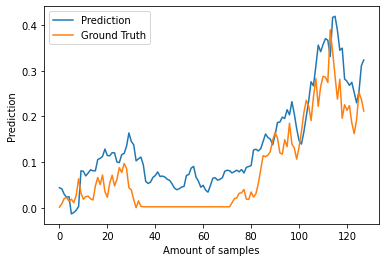

In [26]:

# %% Plotting
# plt.plot(range(len(train_y)), train_y, label='train_y')
plt.plot(range(len(pred_y)), pred_y, label='Prediction')
plt.plot(range(len(pred_y)), test_y, label='Ground Truth')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()
# %%

In [27]:
# # prediction of feature
# df_30_days_past=df.iloc[-7:,:]
# df_30_days_past.tail()
# df_30_days_future=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
# df_30_days_future
# df_30_days_future.shape
# df_30_days_future["Power(MW)"]=0
# df_30_days_future=df_30_days_future[["Speed10" , "Direction10" , "Speed30" , "Direction30" , "Speed50" , "Direction50" , "Speed70" , "Direction70" , "Speed90" , "Direction90" , "Speed100" , "Direction100" , "Temper" , "Pressure" , "Humidity" , "Power(MW)"]]
# old_scaled_array=scaler.transform(df_30_days_past)
# new_scaled_array=scaler.transform(df_30_days_future)
# new_scaled_df=pd.DataFrame(new_scaled_array)
# new_scaled_df.iloc[:,0]=np.nan
# full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
# full_df_scaled_array=full_df.values
# all_data=[]
# time_step=7
# for i in range(time_step,len(full_df_scaled_array)):
#   data_x=[]
#   data_x.append(
#     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
#   data_x=np.array(data_x)
#   prediction=my_model.predict(data_x)
#   all_data.append(prediction)
#   full_df.iloc[i,0]=prediction
# new_array=np.array(all_data)
# new_array=new_array.reshape(-1,1)
# prediction_copies_array = np.repeat(new_array,16, axis=-1)
# y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),16)))[:,0]
# print(y_pred_future_30_days)
# plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')

In [28]:
# total = np.hstack((df_y,y_pred_future_30_days))
# plt.plot(range(len(total)), total, label='Prediction',color='coral')
# plt.plot(range(len(df_y)), df_y, label='Prediction')

In [29]:
# # prediction of feature
# df_30_days_past=df.iloc[-7:,:]
# df_30_days_past.tail()

In [30]:
# df_30_days_future=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
# df_30_days_future
# df_30_days_future.shape

In [31]:
# df_30_days_future["Power(MW)"]=0

In [32]:
# df_30_days_future

In [33]:
# df_30_days_future=df_30_days_future[["Speed10" , "Direction10" , "Speed30" , "Direction30" , "Speed50" , "Direction50" , "Speed70" , "Direction70" , "Speed90" , "Direction90" , "Speed100" , "Direction100" , "Temper" , "Pressure" , "Humidity" , "Power(MW)"]]

In [34]:
# old_scaled_array=scaler.transform(df_30_days_past)

In [35]:
# old_scaled_array.shape

In [36]:
# new_scaled_array=scaler.transform(df_30_days_future)

In [37]:
# new_scaled_array.shape

In [38]:

# new_scaled_df=pd.DataFrame(new_scaled_array)
# new_scaled_df.iloc[:,0]=np.nan
# full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [39]:
# full_df.shape

In [40]:
# full_df_scaled_array=full_df.values
# all_data=[]
# time_step=7
# for i in range(time_step,len(full_df_scaled_array)):
#   data_x=[]
#   data_x.append(
#     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
#   data_x=np.array(data_x)
#   prediction=grid_model.predict(data_x)
#   all_data.append(prediction)
#   full_df.iloc[i,0]=prediction

In [41]:
# new_array=np.array(all_data)
# new_array=new_array.reshape(-1,1)
# prediction_copies_array = np.repeat(new_array,16, axis=-1)
# y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),16)))[:,0]
# print(y_pred_future_30_days)

In [42]:
# plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')